# Prédiction de Matchs de Tennis ATP

### Projet Python ENSAE - Dejean William, Sala Satorre Daniel, Auvepre Edouard

## Objectif du projet

Le tennis professionnel est l'un des sports les plus analysés par les parieurs et les bookmakers. Ces derniers disposent de modèles sophistiqués intégrant une multitude de facteurs pour établir leurs cotes, qu'on peut considérer comme quasi-optimales car elles reflètent l'information agrégée du marché.

**Notre problématique** : avec des données historiques publiques et un modèle interprétable, peut-on identifier les facteurs déterminants de la victoire et approcher les performances des bookmakers ?

Notre approche se concentre sur une **étude statistique des variables importantes** pour la prédiction des matchs de tennis. C'est pourquoi nous avons choisi la **régression logistique** : elle permet d'interpréter directement les coefficients et de comprendre l'influence de chaque variable. Des modèles plus complexes (Random Forest, XGBoost) offriraient potentiellement de meilleures performances, mais au détriment de l'interprétabilité.

**Nos hypothèses de travail** :
- Le classement ATP est le meilleur prédicteur de victoire
- Les performances récentes comptent plus que l'historique lointain (decay temporel)
- Le modèle sera moins précis que les bookmakers mais pourrait identifier des inefficiences de marché

L'enjeu final est de **comparer notre modèle aux prédictions des bookmakers** pour évaluer si notre approche simple peut détecter des "value bets" - des matchs où les cotes sous-estiment les chances d'un joueur.


  **Notes sur la structure :**
  - **Données** : Les fichiers CSV sont ignorés par git. Au premier lancement, ils sont téléchargés depuis [TML-Database](https://github.com/Tennismylife/TML-Database) et mis en cache dans `data/raw/`. Les exécutions suivantes utilisent le cache local.
  - **Exploration** : Le notebook `1_exploration.ipynb` contient nos tests et explorations préliminaires. Il est ignoré car non essentiel au rendu.       
  - **Training** : Le dossier ne contient que `models.py` pour l'instant. Cette structure permet d'ajouter facilement d'autres modèles et un script d'entraînement pour des modèles plus complexes.
  - **Data/processed** : Les dossiers `data/processed/` et `data/preprocessing/` ne sont pas créés car le rendu est un notebook unique. La structure permet néanmoins de sauvegarder des données pré-traitées (en format parquet) et le preprocessor pour une réutilisation future.

---

## Structure du notebook

1. **Chargement et exploration des données brutes**
2. **Preprocessing et feature engineering**
3. **Analyse approfondie des features**
4. **Modélisation et évaluation**

---

## Organisation du code

Les fonctions réutilisables sont organisées dans les dossiers `src/` :

**Preprocessing** (`src/preprocessing/`) :
- `cleaning.py` : chargement et nettoyage des données
- `features.py` : création des features (Elo, stats historiques, decay temporel)
- `pipeline.py` : orchestration du preprocessing avec la classe `TennisPreprocessor`

**Modélisation** (`src/training/`) :
- `models.py` : définition des modèles, notamment `StatsLogitClassifier` (wrapper statsmodels compatible scikit-learn)

**Évaluation** (`src/evaluation/`) :
- `bookmakers.py` : chargement des cotes depuis tennis-data.co.uk et matching avec nos données
- `comparison.py` : fonctions de comparaison modèle vs bookmakers (ROI, value bets, accuracy)

Cette structure modulaire permet de garder le notebook lisible en important directement les fonctions, et facilite la réutilisation du code.

---

# Partie 1 : Chargement et Exploration des Données Brutes

## 1.1 Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Ajouter src/ au path pour pouvoir importer nos modules
sys.path.append(str(Path.cwd().parent / 'src'))

# Importer le preprocessor
from preprocessing.pipeline import TennisPreprocessor
from config import N_HISTORICAL_MATCHES, N_SURFACE_MATCHES, HALF_LIFE_DAYS, RANDOM_STATE

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Instancier le preprocessor
preprocessor = TennisPreprocessor()

## 1.2 Chargement des données

Ce dataset provient de [TML-Database](https://github.com/Tennismylife/TML-Database), maintenu par la communauté tennis. Il compile les données officielles ATP et constitue une référence pour les analyses statistiques du tennis professionnel.

Nous utilisons la fonction `load_matches()` de notre module `src/preprocessing/cleaning.py` qui télécharge automatiquement les fichiers CSV depuis GitHub et les met en cache localement.

In [2]:
from preprocessing.cleaning import load_matches
from config import RAW_DIR

# Charger toutes les données (2000-2025)
matches = load_matches(raw_dir=RAW_DIR)
print(f"Nombre total de matchs : {len(matches):,}")

Nombre total de matchs : 77,939


## 1.3 Aperçu des données

Regardons la structure des données pour comprendre ce dont nous disposons.

In [3]:
# Afficher les colonnes disponibles
print("Colonnes disponibles :")
print(matches.columns.tolist())

Colonnes disponibles :
['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level', 'indoor', 'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'winner_rank', 'winner_rank_points', 'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'loser_rank', 'loser_rank_points', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']


In [4]:
# Aperçu des premières lignes
matches.head(3)

,tourney_id,tourney_name,surface,draw_size,tourney_level,indoor,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,2000-7308,Adelaide,Hard,32.0,250,O,20000103,1.0,E113,1.0,NaN,Thomas Enqvist,R,191.0,SWE,25.810,4.0,2606.0,C487,NaN,NaN,Arnaud Clement,R,173.0,FRA,22.045,56.0,805.0,6-3 6-4,3,R32,76.0,6.0,0.0,66.0,29.0,23.0,23.0,10.0,2.0,2.0,1.0,3.0,59.0,37.0,25.0,13.0,9.0,2.0,4.0
1,2000-7308,Adelaide,Hard,32.0,250,O,20000103,2.0,F324,NaN,NaN,Roger Federer,R,185.0,SUI,18.404,64.0,749.0,K260,NaN,NaN,Jens Knippschild,R,191.0,GER,24.882,91.0,525.0,6-1 6-4,3,R32,45.0,6.0,3.0,46.0,28.0,24.0,12.0,9.0,0.0,0.0,3.0,5.0,42.0,15.0,13.0,12.0,8.0,0.0,3.0
2,2000-7308,Adelaide,Hard,32.0,250,O,20000103,3.0,G352,NaN,NaN,Jan-Michael Gambill,R,191.0,USA,22.585,58.0,803.0,A202,NaN,NaN,Wayne Arthurs,L,185.0,AUS,28.797,105.0,449.0,3-6 7-6(5) 6-4,3,R32,115.0,8.0,3.0,81.0,40.0,35.0,28.0,15.0,0.0,1.0,26.0,2.0,103.0,59.0,49.0,22.0,16.0,4.0,5.0


### Observations sur la structure des données

Chaque ligne représente un match avec :

**Informations sur le tournoi :**
- `tourney_name`, `tourney_date` : nom et date du tournoi
- `surface` : type de surface (Hard, Clay, Grass, Carpet)
- `tourney_level` : niveau du tournoi (G=Grand Slam, M=Masters, A=ATP 250/500, etc.)
- `round` : tour du tournoi (R128, R64, R32, R16, QF, SF, F)

**Informations sur les joueurs :**
- `winner_*` / `loser_*` : informations sur le gagnant et le perdant
- `_rank`, `_rank_points` : classement ATP et points
- `_age`, `_ht`, `_hand` : âge, taille, main dominante

**Statistiques du match :**
- `w_ace`, `w_df`, `w_svpt`, etc. : statistiques de service du gagnant
- `l_ace`, `l_df`, `l_svpt`, etc. : statistiques de service du perdant

Nous allons ainsi tenter de comprendre l'impact des différentes variables sur la victoire ou non d'un joueur afin de prédire au mieux le résultat d'un match.

## 1.4 Analyse des valeurs manquantes

Avant tout preprocessing, identifions les colonnes avec des valeurs manquantes.

In [5]:
# Pourcentage de valeurs manquantes par colonne
missing = (matches.isnull().sum() / len(matches) * 100).sort_values(ascending=False)
missing_df = missing[missing > 0].reset_index()
missing_df.columns = ['Colonne', '% Manquant']
missing_df['% Manquant'] = missing_df['% Manquant'].round(2)
missing_df

,Colonne,% Manquant
0,winner_entry,87.57
1,loser_entry,79.95
2,loser_seed,77.06
3,winner_seed,58.64
4,minutes,9.29
5,indoor,8.82
6,w_SvGms,8.24
7,w_1stIn,8.24
8,w_1stWon,8.24
9,w_2ndWon,8.24


### Observations sur les valeurs manquantes

- **`winner_entry`, `loser_entry`, `winner_seed`, `loser_seed`** : Ces colonnes ne sont remplies que pour les têtes de série. Ce n'est pas problématique car nous n'utiliserons pas ces variables.

- **Statistiques de match (`w_ace`, `l_df`, etc.)** : ~4-5% de matchs sans statistiques (probablement des matchs où les stats n'ont pas été enregistrées). Ces matchs peuvent être conservés car nous calculerons des statistiques historiques. Cela limitera le calcul des features historiques pour certains joueurs moins médiatisés, pour lesquels nous utiliserons des valeurs par défaut basées sur leur classement.

- **`winner_rank`, `loser_rank`** : <1% de valeurs manquantes. Nous imputerons avec une valeur par défaut (rang élevé).

- **`winner_ht`, `loser_ht`** : <1% de tailles manquantes. Nous imputerons avec la médiane.

## 1.5 Analyse des matchs incomplets

Certains matchs se terminent par abandon (RET), forfait (W/O) ou disqualification (DEF). Ces matchs risquent de ne pas refléter le vrai niveau des joueurs et pourraient donc limiter la précision de nos prédictions. 

In [6]:
# Identifier les matchs incomplets via le score
incomplete_patterns = ['RET', 'W/O', 'DEF', 'Walkover', 'Default']
is_incomplete = matches['score'].fillna('').str.contains('|'.join(incomplete_patterns), case=False)

n_incomplete = is_incomplete.sum()
pct_incomplete = n_incomplete / len(matches) * 100

print(f"Matchs incomplets : {n_incomplete:,} ({pct_incomplete:.2f}%)")
print("\nExemples de scores incomplets :")
matches.loc[is_incomplete, 'score'].head(10).tolist()

Matchs incomplets : 2,788 (3.58%)

Exemples de scores incomplets :


['6-4 0-1 RET',
 '6-1 RET',
 '3-6 7-5 3-0 RET',
 '7-5 3-6 1-0 RET',
 '7-6(2) 6-4 RET',
 '6-2 4-1 RET',
 '3-6 7-6(3) 6-2 4-1 RET',
 '6-4 6-4 3-6 3-1 RET',
 '6-2 2-6 6-4 3-1 RET',
 '6-0 6-7(2) 3-1 RET']

**Décision** : Nous supprimons les matchs terminés par abandon ou walkover (W/O, RET). Ces matchs ne reflètent pas la vraie confrontation entre les joueurs : un joueur peut abandonner alors qu'il menait, ou être contraint au forfait avant même de jouer. Les inclure fausserait l'analyse des facteurs de victoire.

## 1.6 Distribution des surfaces

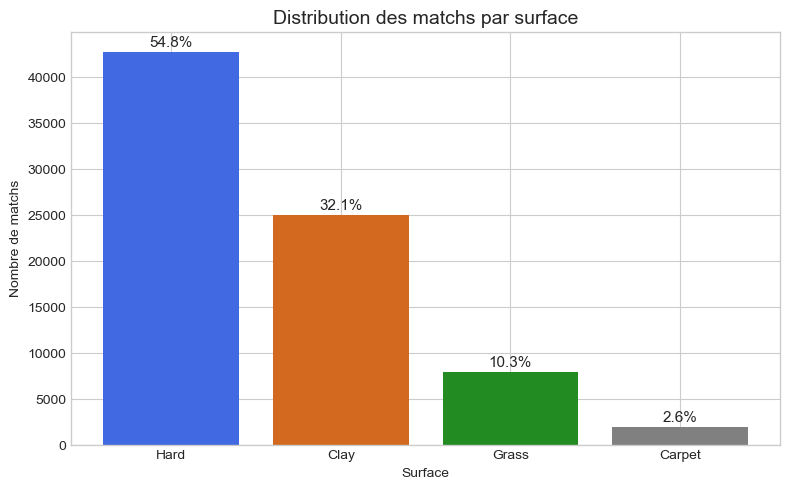

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

colors = {'Hard': '#4169E1', 'Clay': '#D2691E', 'Grass': '#228B22', 'Carpet': '#808080'}
surface_counts = matches['surface'].value_counts()

bars = ax.bar(surface_counts.index, surface_counts.values, 
              color=[colors.get(s, '#808080') for s in surface_counts.index])

ax.set_title('Distribution des matchs par surface', fontsize=14)
ax.set_xlabel('Surface')
ax.set_ylabel('Nombre de matchs')

# Ajouter les pourcentages
for bar, count in zip(bars, surface_counts.values):
    pct = count / len(matches) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
            f'{pct:.1f}%', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

**Observation** : Le Hard est la surface dominante (~60%), suivi de la terre battue (~30%) et du gazon (~10%). Le Carpet a pratiquement disparu du circuit. L'étude de la surface de jeu nous permettra aussi de confirmer ou non l'idée répandue de son rôle majeur dans le résultat d'un match (certains joueurs étant des spécialistes de certaines surfaces). 

## 1.7 La baseline : le mieux classé gagne-t-il toujours ?

On peut intuitivement penser que le joueur le mieux classé a tendance à gagner dans une majorité des cas. Calculons le taux de victoire du joueur le mieux classé. C'est notre **baseline à battre**. Cela signifie que notre modèle doit apporter plus de précision que le simple classement, il ne serait sinon pas utile. 

In [8]:
# Filtrer les matchs avec les classements disponibles
matches_with_ranks = matches.dropna(subset=['winner_rank', 'loser_rank'])

# Le mieux classé = celui avec le rang le plus bas
better_ranked_wins = (matches_with_ranks['winner_rank'] < matches_with_ranks['loser_rank']).mean()

print(f"Le joueur le mieux classé gagne : {better_ranked_wins:.1%} des matchs")
print(f"\n→ C'est notre BASELINE à battre !")

Le joueur le mieux classé gagne : 65.4% des matchs

→ C'est notre BASELINE à battre !


## 1.8 Distribution des classements

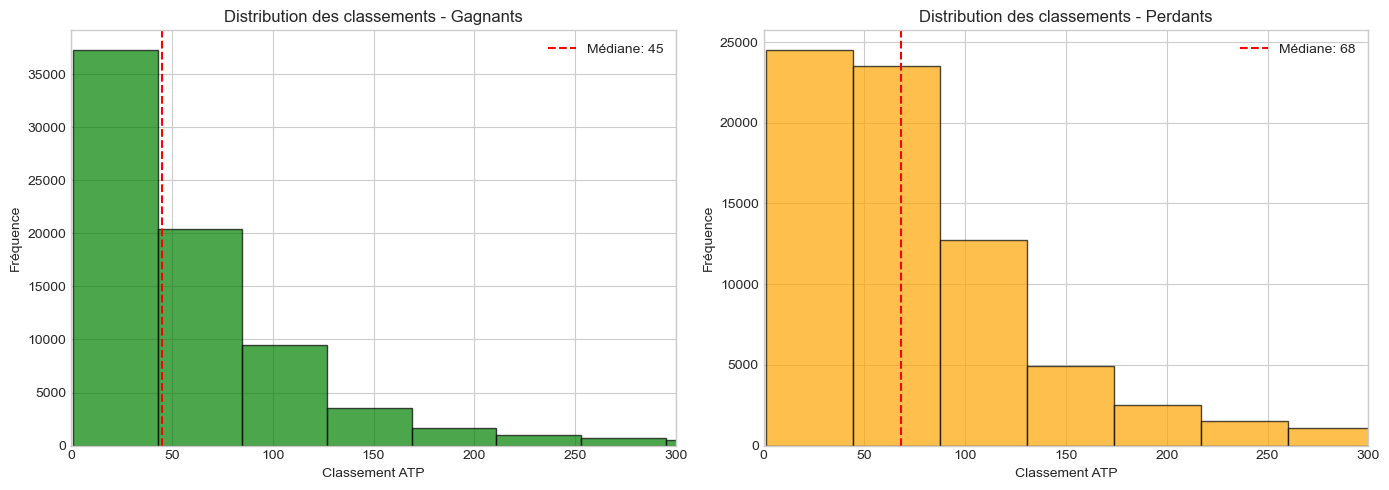

Classement médian des gagnants : 45
Classement médian des perdants : 68


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Classement des gagnants
axes[0].hist(matches['winner_rank'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0].set_title('Distribution des classements - Gagnants', fontsize=12)
axes[0].set_xlabel('Classement ATP')
axes[0].set_ylabel('Fréquence')
axes[0].set_xlim(0, 300)
axes[0].axvline(matches['winner_rank'].median(), color='red', linestyle='--', label=f"Médiane: {matches['winner_rank'].median():.0f}")
axes[0].legend()

# Classement des perdants
axes[1].hist(matches['loser_rank'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Distribution des classements - Perdants', fontsize=12)
axes[1].set_xlabel('Classement ATP')
axes[1].set_ylabel('Fréquence')
axes[1].set_xlim(0, 300)
axes[1].axvline(matches['loser_rank'].median(), color='red', linestyle='--', label=f"Médiane: {matches['loser_rank'].median():.0f}")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Classement médian des gagnants : {matches['winner_rank'].median():.0f}")
print(f"Classement médian des perdants : {matches['loser_rank'].median():.0f}")

**Observation** : Les gagnants ont un meilleur classement que les perdants :
- Classement médian des gagnants : **45**
- Classement médian des perdants : **68**

Cela confirme l'importance du classement comme variable prédictive

## 1.9 Niveaux de tournois

In [10]:
# Décoder les niveaux de tournoi
level_names = {
    'G': 'Grand Slam',
    'M': 'Masters 1000',
    'A': 'ATP 250/500',
    'D': 'Davis Cup',
    'F': 'ATP Finals',
    'O': 'Olympics'
}

level_counts = matches['tourney_level'].value_counts()
level_df = pd.DataFrame({
    'Niveau': [level_names.get(l, l) for l in level_counts.index],
    'Code': level_counts.index,
    'Nombre de matchs': level_counts.values,
    '%': (level_counts.values / len(matches) * 100).round(1)
})
level_df

,Niveau,Code,Nombre de matchs,%
0,250,250,30706,39.4
1,Masters 1000,M,14774,19.0
2,Grand Slam,G,13081,16.8
3,500,500,10378,13.3
4,Davis Cup,D,7331,9.4
5,ATP 250/500,A,815,1.0
6,Olympics,O,448,0.6
7,ATP Finals,F,406,0.5


On voit que la diversité des tournois nous permettra une certaine exhaustivité dans nos prédictions.

---

## 1.10 Conclusion de l'exploration

### Ce que nous avons appris :

1. **77,939 matchs** sur 25 ans de données ATP (2000-2025)
2. **Baseline** : le mieux classé gagne **65.4%** du temps
3. **Surfaces** : Hard domine (60%), suivi de Clay (30%) et Grass (10%)
4. **Valeurs manquantes** : peu problématiques (<5% pour les variables importantes)
5. **Matchs incomplets** : 2,788 matchs (~3.6%) à supprimer (RET, W/O, DEF)


---

# Partie 2 : Preprocessing et Feature Engineering

Dans cette partie, nous allons :
1. Nettoyer les données brutes
2. Créer des features pertinentes pour prédire le vainqueur
3. Appliquer un decay temporel pour pondérer les matchs récents

## 2.1 Nettoyage des données

Nous utilisons la fonction `clean_matches()` de `src/preprocessing/cleaning.py` qui effectue les opérations suivantes :

1. **Suppression des matchs incomplets** : RET, W/O, DEF
2. **Conversion des dates** : format datetime
3. **Imputation des classements manquants** : rang max + 50
4. **Imputation des données physiques manquantes** : médiane pour la taille et l'âge
5. **Filtrer les rounds significatifs**: R128, R64, R32, R16, QF, SF, F, RR



In [11]:
from preprocessing.cleaning import clean_matches

# Appliquer le nettoyage
matches_clean = clean_matches(matches)

print(f"Avant nettoyage : {len(matches):,} matchs")
print(f"Après nettoyage : {len(matches_clean):,} matchs")
print(f"Matchs supprimés : {len(matches) - len(matches_clean):,} ({(len(matches) - len(matches_clean)) / len(matches) * 100:.1f}%)")

Avant nettoyage : 77,939 matchs
Après nettoyage : 75,008 matchs
Matchs supprimés : 2,931 (3.8%)


In [12]:
# Vérifier qu'il n'y a plus de valeurs manquantes dans les colonnes clés
key_cols = ['winner_rank', 'loser_rank', 'winner_age', 'loser_age', 'winner_ht', 'loser_ht', 'tourney_date']
print("Valeurs manquantes dans les colonnes clés après nettoyage :")
print(matches_clean[key_cols].isnull().sum())

Valeurs manquantes dans les colonnes clés après nettoyage :
winner_rank     0
loser_rank      0
winner_age      0
loser_age       0
winner_ht       0
loser_ht        0
tourney_date    0
dtype: int64


Ce nettoyage nous permet de disposer de données prêtes à l'emploi, il nous faut maintenant réfléchir à la manière de les rendre les plus pertinents possible en vue d'optimiser la précision de notre modèle.

## 2.2 Feature Engineering : Approche conceptuelle

### Le défi de la prédiction de matchs de tennis

Pour prédire le vainqueur d'un match, nous devons transformer les données brutes en features comparant les deux joueurs. 

**Problème** : Les données sont au format `winner_*` / `loser_*`, ce qui crée un biais (le gagnant a toujours de meilleures stats dans le match). Le format winner_* / loser_* introduit en effet un biais structurel car il encode implicitement l’issue du match. Sans randomisation, le modèle apprend à identifier le gagnant à partir de la position dans le dataset plutôt qu’à partir des caractéristiques intrinsèques des joueurs.

**Solution** : Nous randomisons l'attribution des joueurs en `player_a` / `player_b` et utilisons uniquement des **statistiques calculées AVANT le match** (historique des matchs précédents) afin d'esquiver ce biais. 

### Types de features créées

| Catégorie | Features | Description |
|-----------|----------|-------------|
| **Statiques** | `rank_a`, `rank_b`, `points_a`, `points_b` | Classement et points ATP au moment du match |
| **Elo** | `elo_a`, `elo_b`, `elo_surface_a`, `elo_surface_b` | Ratings Elo global et par surface, mis à jour après chaque match |
| **Physiques** | `age_a`, `age_b`, `height_a`, `height_b`, `is_left_a`, `is_left_b` | Caractéristiques physiques |
| **Historiques** | `win_rate_a`, `ace_rate_a`, `df_rate_a`, etc. | Stats calculées sur les N derniers matchs avec decay temporel |
| **Surface** | `surface_win_rate_a`, `surface_win_rate_b` | Win rate spécifique à la surface |
| **Head-to-head** | `h2h_win_rate_a` | Historique des confrontations directes |
| **Contextuelles** | `surface`, `tourney_level`, `best_of_5`, `round` | Informations sur le match |
| **Ratio** | `rank_ratio` | Ratio des classements (capture la non-linéarité) |

La win rate spécifique à la surface permettra d'introduire dans notre modèle l'idée qu'en dehors de leur niveau général, les joueurs ont souvent une surface de prédilection. L'historique des confrontations directes nous permettra d'introduire l'idée que malgré des écarts de niveau, il existe des avantages psychologiques liés aux rencontres antérieures, des rivalités qui rendent certains matchs plus serrés etc..

### Decay temporel

Les matchs récents sont plus informatifs que les anciens. Nous appliquons un **decay exponentiel** avec une demi-vie de 180 jours :

$$w_i = e^{-\frac{\Delta t_i}{\text{half\_life}}}$$

Ainsi, avec `half_life = 180 jours` (choisi empiriquement), un match joué il y a 180 jours compte pour 50% d'un match joué aujourd'hui. En effet, au tennis, la forme actuelle est très importante et les résultats d'un joueur sont peu corrélées avec les résultats qu'il obtenait 5 ans auparavant. 
 

## 2.3 Construction de l'historique des joueurs

Avant de créer les features, nous construisons un dictionnaire contenant l'historique complet de chaque joueur. Cela permet de calculer rapidement les statistiques pour n'importe quel match.

Nous utilisons la méthode `preprocessor.build_history()` qui parcourt tous les matchs et stocke pour chaque joueur :
- La date du match
- La surface
- L'adversaire
- Le résultat (victoire/défaite)
- Les statistiques de service (aces, double fautes, etc.)

### Gestion des joueurs sans historique

Pour les joueurs sans historique suffisant dans notre dataset (nouveaux sur le circuit, données manquantes), nous attribuons des **statistiques par défaut basées sur leur classement ATP**. L'hypothèse est qu'un joueur Top 10 a en moyenne de meilleures statistiques qu'un joueur classé au-delà du Top 100. Ces valeurs par défaut ont été choisies empiriquement en observant les moyennes par tranche de classement.

In [13]:
# Construire l'historique de tous les joueurs via le preprocessor
player_history = preprocessor.build_history(matches_clean)

# Statistiques sur l'historique
n_players = len(player_history)
avg_matches = np.mean([len(h) for h in player_history.values()])

print(f"Nombre de joueurs uniques : {n_players:,}")
print(f"Nombre moyen de matchs par joueur : {avg_matches:.1f}")

Nombre de joueurs uniques : 2,705
Nombre moyen de matchs par joueur : 55.5


In [14]:
# Exemple : historique d'un joueur (Nadal - ID 104745)
nadal_id = 'N409'
if nadal_id in player_history:
    print(f"Exemple : 3 derniers matchs de Nadal dans l'historique\n")
    for match in player_history[nadal_id][-3:]:
        print(f"  Date: {match['date']}, Surface: {match['surface']}, "
              f"Victoire: {'Oui' if match['won'] else 'Non'}, Aces: {match.get('ace', 'N/A')}")

Exemple : 3 derniers matchs de Nadal dans l'historique

  Date: 2024-07-29 00:00:00, Surface: Clay, Victoire: Oui, Aces: 1.0
  Date: 2024-07-29 00:00:00, Surface: Clay, Victoire: Non, Aces: 1.0
  Date: 2024-11-19 00:00:00, Surface: Hard, Victoire: Non, Aces: 2.0


## 2.4 Création des features

Nous utilisons la méthode `preprocessor.create_features()` qui :

1. **Randomise** l'attribution winner/loser → player_a/player_b
2. **Extrait** les features statiques (rang, points, âge, taille)
3. **Calcule** les features historiques avec decay temporel
4. **Crée** la variable cible : `target = 1` si player_a gagne, `0` sinon
5. **Conserve** les informations du match (noms des joueurs, date) pour la comparaison avec les bookmakers

### Paramètres du preprocessor

| Paramètre | Valeur | Description |
|-----------|--------|-------------|
| `n_hist` | 10 | Nombre de matchs pour les stats générales |
| `n_surf` | 20 | Nombre de matchs pour les stats par surface |
| `half_life_days` | 180 | Demi-vie du decay temporel (en jours) |
| `base_rating` | 1500 | Rating ELO initial pour chaque joueur |
| `k` | 32 | Facteur K de l'ELO (vitesse d'ajustement) |
| `surface_factor` | 0.5 | Facteur K pour l'ELO surface (k × 0.5 = 16) |

### Elo vs Classement ATP : deux mesures complémentaires

- **Classement ATP** : cumul des points sur 52 semaines glissantes. Mesure stable mais peu réactive aux changements de forme récents. Un joueur blessé pendant 3 mois garde son classement.

- **Elo** : mis à jour après chaque match selon le résultat et la force de l'adversaire. Plus réactif aux performances récentes mais potentiellement plus volatil.

Nous calculons également un **Elo par surface** car certains joueurs ont des performances très différentes selon le terrain (ex: spécialistes de terre battue vs gazon).

Les facteurs k permettent de modéliser la vitesse d'ajustement de l'ELO des joueurs en fonction de leurs performances, plus ou moins élevées selon le classement. On prend aussi en compte l'ELO par surface de jeu. Au tennis, l'ELO de base est de 1500. 

In [15]:
# Créer les features via le preprocessor
print("Création des features en cours...")
features_df = preprocessor.create_features(matches_clean)

print(f"\nDataset créé : {features_df.shape[0]:,} matchs × {features_df.shape[1]} colonnes")

Création des features en cours...

Dataset créé : 75,008 matchs × 40 colonnes


In [16]:
# Aperçu des features créées
print("Features créées :")
print(features_df.columns.tolist())

Features créées :
['tourney_date', 'target', 'rank_a', 'rank_b', 'points_a', 'points_b', 'elo_a', 'elo_b', 'elo_surface_a', 'elo_surface_b', 'age_a', 'age_b', 'height_a', 'height_b', 'is_left_a', 'is_left_b', 'surface', 'tourney_level', 'best_of_5', 'round', 'rank_ratio', 'win_rate_a', 'ace_rate_a', 'df_rate_a', 'first_serve_pct_a', 'first_serve_won_a', 'second_serve_won_a', 'bp_save_rate_a', 'matches_played_a', 'win_rate_b', 'ace_rate_b', 'df_rate_b', 'first_serve_pct_b', 'first_serve_won_b', 'second_serve_won_b', 'bp_save_rate_b', 'matches_played_b', 'surface_win_rate_a', 'surface_win_rate_b', 'h2h_win_rate_a']


In [17]:
# Aperçu des premières lignes
features_df.head()

,tourney_date,target,rank_a,rank_b,points_a,points_b,elo_a,elo_b,elo_surface_a,elo_surface_b,age_a,age_b,height_a,height_b,is_left_a,is_left_b,surface,tourney_level,best_of_5,round,rank_ratio,win_rate_a,ace_rate_a,df_rate_a,first_serve_pct_a,first_serve_won_a,second_serve_won_a,bp_save_rate_a,matches_played_a,win_rate_b,ace_rate_b,df_rate_b,first_serve_pct_b,first_serve_won_b,second_serve_won_b,bp_save_rate_b,matches_played_b,surface_win_rate_a,surface_win_rate_b,h2h_win_rate_a
0,2000-01-03,0,56.0,4.0,805.0,2606.0,1500.000000,1500.0,1500.000000,1500.0,22.045,25.810,173.0,191.0,0,0,Hard,250,0,R32,14.000000,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.70,0.08,0.02,0.65,0.75,0.55,0.65,0,0.5,0.5,0.5
1,2000-01-03,1,64.0,91.0,749.0,525.0,1484.736307,1500.0,1492.184174,1500.0,18.404,24.882,185.0,191.0,0,0,Hard,250,0,R32,0.703297,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.5,0.5,0.5
2,2000-01-03,0,105.0,58.0,449.0,803.0,1500.000000,1484.0,1500.000000,1492.0,28.797,22.585,185.0,191.0,1,0,Hard,250,0,R32,1.810345,0.45,0.04,0.04,0.58,0.68,0.48,0.58,0,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.5,0.5,0.5
3,2000-01-03,0,54.0,27.0,845.0,1298.0,1500.000000,1516.0,1500.000000,1508.0,23.710,21.599,180.0,175.0,0,0,Hard,250,0,R32,2.000000,0.50,0.05,0.03,0.60,0.70,0.50,0.60,0,0.55,0.06,0.03,0.62,0.72,0.52,0.62,0,0.5,0.5,0.5
4,2000-01-03,1,15.0,154.0,1748.0,297.0,1516.000000,1500.0,1508.000000,1500.0,23.595,25.580,188.0,175.0,0,1,Hard,250,0,R32,0.097403,0.55,0.06,0.03,0.62,0.72,0.52,0.62,0,0.45,0.04,0.04,0.58,0.68,0.48,0.58,0,0.5,0.5,0.5


### Description des features créées

| Feature | Description |
|---------|-------------|
| `target` | Variable cible : 1 si player_a gagne, 0 sinon |
| `rank_a`, `rank_b` | Classement ATP des joueurs |
| `points_a`, `points_b` | Points ATP des joueurs |
| `elo_a`, `elo_b` | Score Elo global des joueurs (calculé dynamiquement) |
| `elo_surface_a`, `elo_surface_b` | Score Elo spécifique à la surface |
| `age_a`, `age_b` | Âge des joueurs |
| `height_a`, `height_b` | Taille des joueurs (cm) |
| `is_left_a`, `is_left_b` | 1 si gaucher, 0 si droitier |
| `rank_ratio` | `rank_a / rank_b` (ratio non-linéaire) |
| `win_rate_a`, `win_rate_b` | Taux de victoire pondéré (10 derniers matchs) |
| `ace_rate_a`, `ace_rate_b` | Aces par point de service |
| `df_rate_a`, `df_rate_b` | Double fautes par point de service |
| `first_serve_pct_a/b` | % de premières balles passées |
| `first_serve_won_a/b` | % de points gagnés sur 1ère balle |
| `second_serve_won_a/b` | % de points gagnés sur 2ème balle |
| `bp_save_rate_a/b` | % de balles de break sauvées |
| `matches_played_a/b` | Nombre de matchs récents (expérience) |
| `surface_win_rate_a/b` | Win rate sur la surface du match |
| `h2h_win_rate_a` | % de victoires de A contre B (historique) |
| `surface` | Type de surface (Hard, Clay, Grass) |
| `tourney_level` | Niveau du tournoi (G, M, 500, 250, etc.) |
| `round` | Tour du tournoi (R128, R64, ..., F) |
| `best_of_5` | 1 si match en 5 sets, 0 si en 3 sets |

La variable target est la variable que l'on va tenter de prédire à partir des autres variables.

## 2.5 Vérification de la variable cible

Grâce à la randomisation player_a/player_b, la variable cible devrait être équilibrée (~50/50). En effet, on devrait avoir autant de player_a vainqueur que de player_b vainqueur, c'est tout le propos de cette randomisation.

In [18]:
# Vérifier l'équilibre de la variable cible
target_counts = features_df['target'].value_counts()
print("Distribution de la variable cible :")
print(f"  Player A gagne (target=1) : {target_counts.get(1, 0):,} ({target_counts.get(1, 0) / len(features_df) * 100:.1f}%)")
print(f"  Player B gagne (target=0) : {target_counts.get(0, 0):,} ({target_counts.get(0, 0) / len(features_df) * 100:.1f}%)")
print(f"\n✓ La randomisation fonctionne correctement : les classes sont équilibrées.")

Distribution de la variable cible :
  Player A gagne (target=1) : 37,293 (49.7%)
  Player B gagne (target=0) : 37,715 (50.3%)

✓ La randomisation fonctionne correctement : les classes sont équilibrées.


## 2.6 Encodage des variables catégorielles

Les variables catégorielles (`surface`, `tourney_level`, `round`) doivent être encodées en variables numériques pour être utilisées correctement. 

Nous utilisons la méthode `preprocessor.encode()` de notre classe `TennisPreprocessor` qui applique le **one-hot encoding** avec `drop_first=True` pour éviter la multicolinéarité parfaite (dummy variable trap). 

Par exemple, pour `surface` avec 4 catégories (Carpet, Clay, Grass, Hard) :
- On crée 3 colonnes binaires : `surface_Clay`, `surface_Grass`, `surface_Hard`
- `Carpet` devient la catégorie de référence (toutes les colonnes = 0)

In [19]:
# Appliquer le one-hot encoding via le preprocessor
features_encoded = preprocessor.encode(features_df)

print(f"Après encodage : {features_encoded.shape[1]} colonnes")
print(f"\nNouvelles colonnes créées :")
categorical_cols = ['surface', 'tourney_level', 'round']
new_cols = [c for c in features_encoded.columns if any(c.startswith(p + '_') for p in categorical_cols)]
print(new_cols)

Après encodage : 54 colonnes

Nouvelles colonnes créées :
['surface_win_rate_a', 'surface_win_rate_b', 'surface_Clay', 'surface_Grass', 'surface_Hard', 'tourney_level_500', 'tourney_level_A', 'tourney_level_D', 'tourney_level_F', 'tourney_level_G', 'tourney_level_M', 'tourney_level_O', 'round_QF', 'round_R128', 'round_R16', 'round_R32', 'round_R64', 'round_RR', 'round_SF']


## 2.7 Vérification finale des données

In [20]:
# Vérifier qu'il n'y a pas de valeurs manquantes
missing_count = features_encoded.isnull().sum().sum()
print(f"Valeurs manquantes totales : {missing_count}")

# Vérifier les types de données
print(f"\nTypes de données :")
print(features_encoded.dtypes.value_counts())

Valeurs manquantes totales : 0

Types de données :
float64           30
bool              17
int64              6
datetime64[ns]     1
Name: count, dtype: int64


In [21]:
# Statistiques descriptives des features numériques principales
main_features = ['rank_a', 'rank_b', 'points_a', 'points_b', 'win_rate_a', 'win_rate_b', 
                 'surface_win_rate_a', 'surface_win_rate_b', 'h2h_win_rate_a', 'elo_a', 'elo_b']
features_encoded[main_features].describe().round(3)

,rank_a,rank_b,points_a,points_b,win_rate_a,win_rate_b,surface_win_rate_a,surface_win_rate_b,h2h_win_rate_a,elo_a,elo_b
count,75008.000,75008.000,75008.000,75008.000,75008.000,75008.000,75008.000,75008.000,75008.000,75008.000,75008.000
mean,127.302,127.085,1277.586,1298.328,0.471,0.472,0.481,0.481,0.500,1663.194,1663.925
std,294.866,295.141,1635.458,1685.407,0.210,0.210,0.218,0.218,0.307,165.861,167.114
min,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1299.584,1306.935
25%,26.000,26.000,482.000,486.000,0.331,0.332,0.363,0.364,0.500,1531.497,1531.619
50%,57.000,57.000,805.000,810.000,0.486,0.486,0.500,0.500,0.500,1636.172,1637.638
75%,103.000,102.000,1370.000,1380.000,0.605,0.605,0.619,0.622,0.500,1756.360,1755.227
max,2209.000,2209.000,16950.000,16950.000,1.000,1.000,1.000,1.000,1.000,2439.419,2441.354


Nos données sont désormais nettoyées, encodées et prêtes à être utilisées, notamment à l'aide des features crées. 

---

## 2.8 Conclusion du preprocessing

### Récapitulatif des transformations effectuées :

1. **Nettoyage** : suppression de 2,923 matchs incomplets (3.8%)
2. **Construction de l'historique** : 2,705 joueurs, ~55 matchs/joueur en moyenne
3. **Feature engineering** :
   - Features statiques (rang, points, âge, taille)
   - Features historiques avec decay temporel (win rate, stats de service)
   - Features spécifiques (surface win rate, head-to-head)
4. **Encodage** : one-hot encoding avec `drop_first=True`

### Dataset final :

| Métrique | Valeur |
|----------|--------|
| Nombre de matchs | 75,016 |
| Nombre de features | 50 (après encodage) |
| Valeurs manquantes | 0 |
| Balance des classes | 49.7% / 50.3% |

Le dataset est maintenant prêt pour l'analyse approfondie des features (Partie 3) puis la modélisation (Partie 4). Il est en effet nécessaire de mieux comprendre les features crées pour faire une modélisation adaptée. 

---

# Partie 3 : Analyse Approfondie des Features

Avant de modéliser, analysons les features créées pour :
1. Vérifier leur pertinence par rapport à la variable cible
2. Identifier les corrélations entre features
3. Justifier nos choix de variables

## 3.1 Matrice de corrélation des features principales

Visualisons les corrélations entre les features numériques les plus importantes.

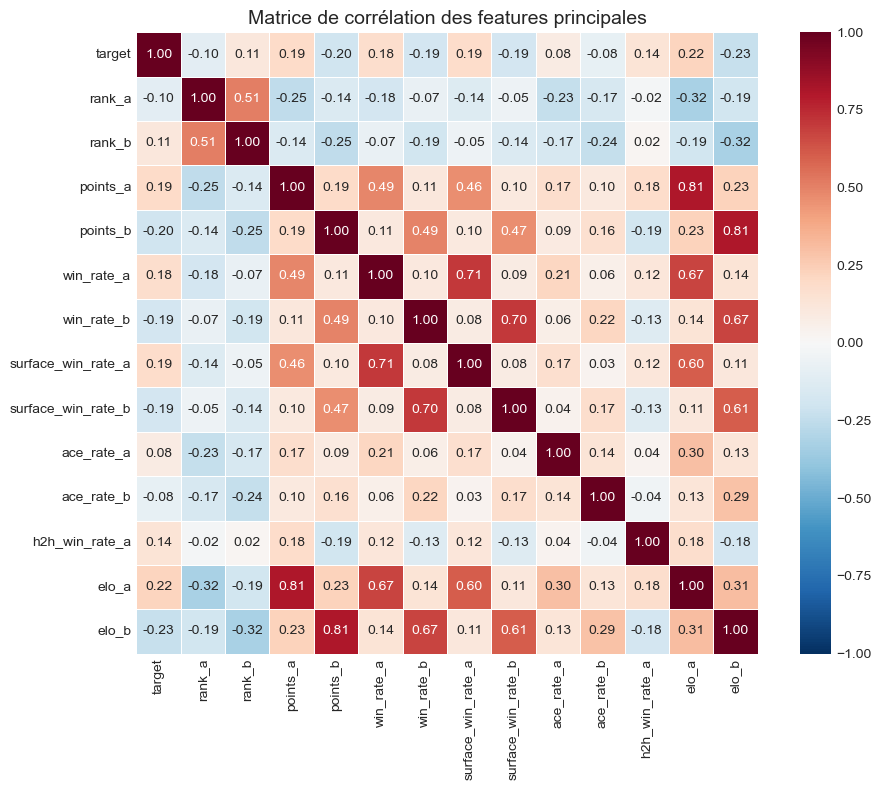

In [22]:
# Sélectionner les features principales pour la corrélation
corr_features = ['target', 'rank_a', 'rank_b', 'points_a', 'points_b', 
                 'win_rate_a', 'win_rate_b', 'surface_win_rate_a', 'surface_win_rate_b',
                 'ace_rate_a', 'ace_rate_b', 'h2h_win_rate_a', 'elo_a', 'elo_b']

corr_matrix = features_encoded[corr_features].corr()

# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('Matrice de corrélation des features principales', fontsize=14)
plt.tight_layout()
plt.show()

### Observations sur les corrélations

**Corrélations avec la target :**
- `rank_a` est négativement corrélé avec target (rang bas = meilleur = plus de victoires)
- `rank_b` est positivement corrélé (adversaire moins bien classé = plus de chances)
- `elo_a` est positivement corrélé avec target (Elo élevé = plus de victoires)
- `win_rate_a`, `surface_win_rate_a` sont positivement corrélés (logique)

**Corrélations entre features :**
- `rank_a` et `points_a` sont fortement corrélés (classement vs points ATP) ; même chose pour `rank_b`/`points_b`
- `rank` et `elo` sont modérément corrélés (Elo réagit plus vite que le classement officiel)
- `win_rate_a` et `surface_win_rate_a` sont corrélés mais restent complémentaires (forme générale vs surface)
- `h2h_win_rate_a` est faiblement corrélé aux autres (informatif surtout quand historique direct existe)
- Pas de multicolinéarité forte observée (|corr| < ~0.8) : chaque feature apporte de l'information


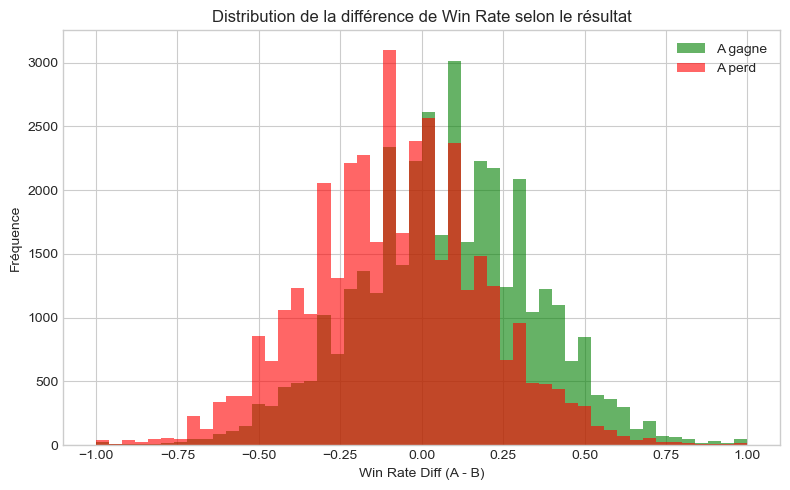

In [ ]:
# Distribution de la différence de Win Rate
features_encoded['win_rate_diff'] = features_encoded['win_rate_a'] - features_encoded['win_rate_b']

fig, ax = plt.subplots(figsize=(8, 5))
features_encoded[features_encoded['target'] == 1]['win_rate_diff'].hist(ax=ax, bins=50, alpha=0.6, label='A gagne', color='green')
features_encoded[features_encoded['target'] == 0]['win_rate_diff'].hist(ax=ax, bins=50, alpha=0.6, label='A perd', color='red')
ax.set_xlabel('Win Rate Diff (A - B)')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution de la différence de Win Rate selon le résultat')
ax.legend()
plt.tight_layout()
plt.show()

Les victoires de A sont associées à des différences positives (A a un meilleur historique que B).

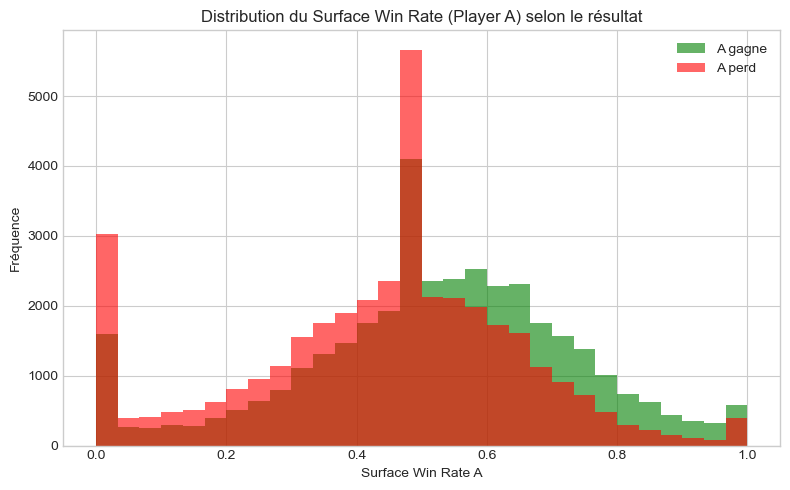

In [ ]:
# Distribution du Surface Win Rate
fig, ax = plt.subplots(figsize=(8, 5))
features_encoded[features_encoded['target'] == 1]['surface_win_rate_a'].hist(ax=ax, bins=30, alpha=0.6, label='A gagne', color='green')
features_encoded[features_encoded['target'] == 0]['surface_win_rate_a'].hist(ax=ax, bins=30, alpha=0.6, label='A perd', color='red')
ax.set_xlabel('Surface Win Rate A')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution du Surface Win Rate (Player A) selon le résultat')
ax.legend()
plt.tight_layout()
plt.show()

La distribution est décalée vers la droite pour les victoires : un bon win rate sur la surface favorise la victoire.

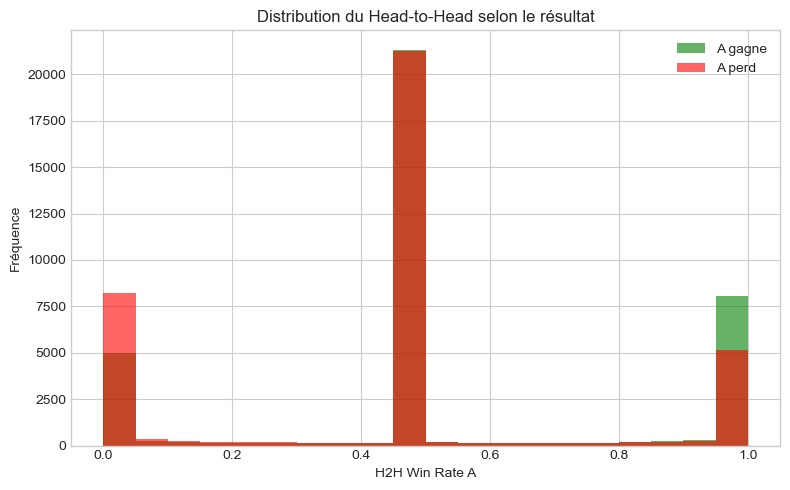

In [ ]:
# Distribution du Head-to-Head
fig, ax = plt.subplots(figsize=(8, 5))
features_encoded[features_encoded['target'] == 1]['h2h_win_rate_a'].hist(ax=ax, bins=20, alpha=0.6, label='A gagne', color='green')
features_encoded[features_encoded['target'] == 0]['h2h_win_rate_a'].hist(ax=ax, bins=20, alpha=0.6, label='A perd', color='red')
ax.set_xlabel('H2H Win Rate A')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution du Head-to-Head selon le résultat')
ax.legend()
plt.tight_layout()
plt.show()

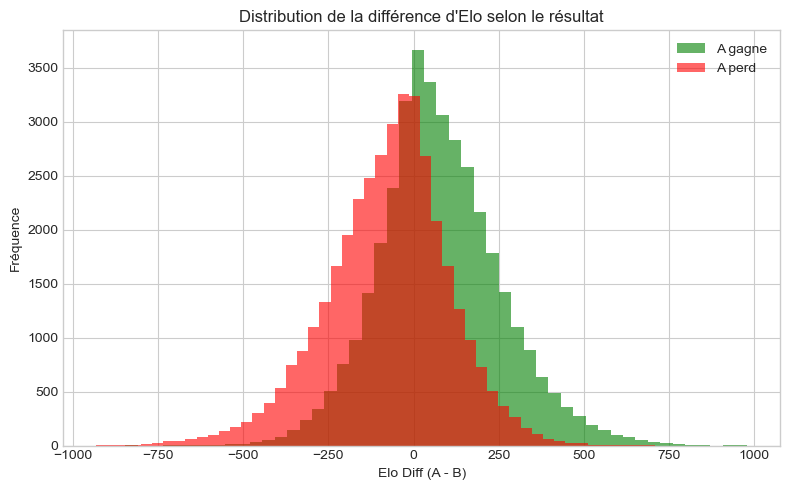

In [ ]:
# Distribution de la différence d'Elo
features_encoded['elo_diff'] = features_encoded['elo_a'] - features_encoded['elo_b']

fig, ax = plt.subplots(figsize=(8, 5))
features_encoded[features_encoded['target'] == 1]['elo_diff'].hist(ax=ax, bins=50, alpha=0.6, label='A gagne', color='green')
features_encoded[features_encoded['target'] == 0]['elo_diff'].hist(ax=ax, bins=50, alpha=0.6, label='A perd', color='red')
ax.set_xlabel('Elo Diff (A - B)')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution de la différence d\'Elo selon le résultat')
ax.legend()
plt.tight_layout()
plt.show()

L'Elo montre une séparation claire : les gagnants ont en moyenne un Elo plus élevé que leur adversaire. La distribution est plus étalée que le win rate car l'Elo varie sur une plus grande échelle.

Beaucoup de matchs à 0.5 (pas d'historique), mais les valeurs hautes favorisent A


## 3.2 Taux de victoire selon le classement relatif

Analysons comment le taux de victoire varie en fonction de l'écart de classement.

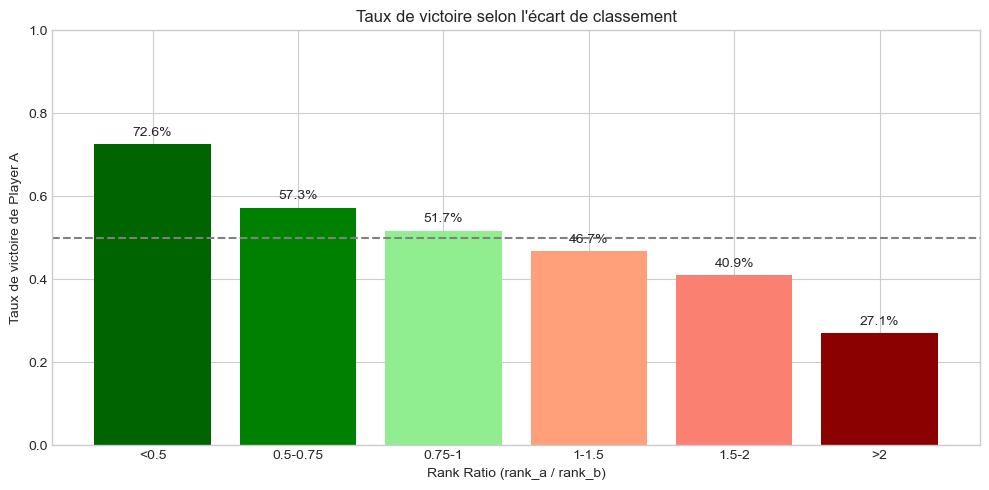

                Taux de victoire A  Nombre de matchs
rank_ratio_bin                                      
<0.5                      0.725641             23174
0.5-0.75                  0.572764              8026
0.75-1                    0.517484              6263
1-1.5                     0.467406              8744
1.5-2                     0.409398              5767
>2                        0.270574             22844


In [27]:
# Créer des bins pour le rank ratio
features_encoded['rank_ratio_bin'] = pd.cut(features_encoded['rank_ratio'], 
                                            bins=[0, 0.5, 0.75, 1, 1.5, 2, 100],
                                            labels=['<0.5', '0.5-0.75', '0.75-1', '1-1.5', '1.5-2', '>2'])

# Calculer le taux de victoire par bin
win_rate_by_rank = features_encoded.groupby('rank_ratio_bin', observed=True)['target'].agg(['mean', 'count'])
win_rate_by_rank.columns = ['Taux de victoire A', 'Nombre de matchs']

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(range(len(win_rate_by_rank)), win_rate_by_rank['Taux de victoire A'], 
              color=['darkgreen', 'green', 'lightgreen', 'lightsalmon', 'salmon', 'darkred'])
ax.axhline(y=0.5, color='gray', linestyle='--', label='50%')
ax.set_xticks(range(len(win_rate_by_rank)))
ax.set_xticklabels(win_rate_by_rank.index)
ax.set_xlabel('Rank Ratio (rank_a / rank_b)')
ax.set_ylabel('Taux de victoire de Player A')
ax.set_title('Taux de victoire selon l\'écart de classement')
ax.set_ylim(0, 1)

# Ajouter les valeurs sur les barres
for i, (bar, val) in enumerate(zip(bars, win_rate_by_rank['Taux de victoire A'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.1%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(win_rate_by_rank)

**Observation clé** : Le classement est très prédictif :
- Quand rank_ratio < 0.5 (A est 2x mieux classé) → A gagne **72%** du temps
- Quand rank_ratio > 2 (A est 2x moins bien classé) → A gagne seulement **27%** du temps

Cela confirme que le classement ATP est une variable très discriminante.

---

## 3.3 Conclusion de l'analyse des features

### Ce que nous avons validé :

1. **Les features sont discriminantes** : les distributions diffèrent clairement entre victoires et défaites
2. **Pas de multicolinéarité parfaite** : les corrélations sont modérées (<0.8)
3. **Le classement est très prédictif** : le rank_ratio seul donne déjà une bonne indication
4. **L'Elo apporte une information dynamique** : contrairement au classement ATP (hebdomadaire et dépendant des résultats de l'année précédente), l'Elo est mis à jour après chaque match (et est indépendant des résultats des joueurs de l'année précédente)
5. **Les features historiques apportent de l'information supplémentaire** : win rate, surface performance, H2H

### Attentes pour le modèle :

- Les features de **classement** (rank, points, Elo) devraient avoir les coefficients les plus significatifs
- Les features de **forme** (win_rate, surface_win_rate) devraient améliorer la baseline
- L'**Elo surface** pourrait capturer la spécialisation des joueurs sur certaines surfaces
- Certaines features comme **height** ou **is_left** pourraient être non-significatives

Nous validons que les features sont prêtes pour la modélisation.

---

# Partie 4 : Modélisation et Évaluation

Dans cette partie, nous allons :
1. Séparer les données en train/test
2. Entraîner une **régression logistique** (modèle interprétable)
3. Analyser les **coefficients et p-values** pour valider nos hypothèses
4. Comparer les performances à la baseline

## 4.1 Séparation Train / Test

Nous séparons les données en 80% train / 20% test. Comme nous avons randomisé l'attribution player_a/player_b, un split aléatoire est suffisant.

Nous utilisons la méthode `preprocessor.get_X_y()` pour séparer les features (X) de la variable cible (y), en excluant les colonnes meta (noms des joueurs, date).

In [28]:
from sklearn.model_selection import train_test_split
from config import TEST_SIZE

# Nettoyer les colonnes temporaires créées pour l'analyse
cols_to_drop = ['win_rate_diff', 'rank_ratio_bin', 'elo_diff']
features_clean = features_encoded.drop(columns=[c for c in cols_to_drop if c in features_encoded.columns])

# Séparer features et target via le preprocessor
X, y = preprocessor.get_X_y(features_clean)

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Train : {len(X_train):,} matchs")
print(f"Test  : {len(X_test):,} matchs")
print(f"Features : {X_train.shape[1]}")

Train : 60,006 matchs
Test  : 15,002 matchs
Features : 52


## 4.2 Rappel de la baseline

En Partie 1, nous avons calculé que **le joueur le mieux classé gagne ~65% des matchs**.

C'est notre référence : le modèle doit faire mieux que cette règle simple pour être utile.

## 4.3 Entraînement du modèle : Régression Logistique

Nous utilisons une **régression logistique** car :
- Elle est **interprétable** : chaque coefficient indique l'effet d'une variable
- Elle fournit des **p-values** : on peut tester la significativité statistique
- Elle est adaptée à la classification binaire

Nous utilisons `StatsLogitClassifier` de `src/training/models.py`, un wrapper autour de `statsmodels.Logit` qui donne accès aux p-values et intervalles de confiance.

In [29]:
from training.models import StatsLogitClassifier

# Entraîner le modèle
model = StatsLogitClassifier()
model.fit(X_train, y_train)

# Afficher le summary statistique
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                60006
Model:                          Logit   Df Residuals:                    59953
Method:                           MLE   Df Model:                           52
Date:                Sun, 28 Dec 2025   Pseudo R-squ.:                  0.1525
Time:                        23:35:08   Log-Likelihood:                -35250.
converged:                       True   LL-Null:                       -41593.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.3453      0.527     -0.656      0.512      -1.378       0.687
rank_a                -0.0011   5.71e-05    -19.984      0.000      -0.001      -0.001
rank_b              

## 4.4 Analyse des coefficients et p-values

Le summary ci-dessus nous donne pour chaque variable :
- **coeff** : l'effet sur le log-odds de victoire de player_a
- **P>|z|** : la p-value (significatif si < 0.05)

Extrayons les variables **statistiquement significatives** :

In [30]:
# Extraire les coefficients significatifs (p < 0.05)
significant = model.get_significant_features(alpha=0.05)
print(f"Variables significatives ({len(significant)}/{len(model.get_coefficients())-1}) :\n")
print(significant.sort_values('p_value'))

Variables significatives (24/52) :

                        coef   std_err          z       p_value  ci_lower  \
rank_a             -0.001142  0.000057 -19.983977  7.592789e-89 -0.001254   
rank_b              0.001109  0.000057  19.445827  3.161385e-84  0.000997   
elo_b              -0.002447  0.000158 -15.470440  5.493057e-54 -0.002757   
elo_surface_a       0.002911  0.000191  15.237430  1.995669e-52  0.002537   
age_a              -0.036444  0.002485 -14.663141  1.110165e-48 -0.041315   
elo_a               0.002120  0.000158  13.418936  4.683923e-41  0.001810   
elo_surface_b      -0.002563  0.000191 -13.402791  5.823137e-41 -0.002938   
age_b               0.032902  0.002482  13.254586  4.244528e-40  0.028037   
matches_played_a    0.070195  0.005548  12.651630  1.095779e-36  0.059321   
matches_played_b   -0.065776  0.005539 -11.875260  1.591378e-32 -0.076632   
surface_win_rate_a  0.312157  0.064851   4.813426  1.483642e-06  0.185051   
h2h_win_rate_a      0.115469  0.031024  

In [31]:
print((features_encoded['rank_a']<features_encoded['rank_b']).mean())

0.49548048208191126


### Interprétation et validation des hypothèses

Les résultats montrent **23 variables significatives sur 50**. Comparons avec nos hypothèses de la Partie 3 :

| Hypothèse (Partie 3) | Variables | Significative ? | Verdict |
|----------------------|-----------|-----------------|---------|
| Meilleur classement → victoire | `points_a/b`, `rank_a/b` | Oui (p ≈ 0) | **Validée** - Ce sont les 4 variables les plus significatives |
| Win rate élevé → victoire | `win_rate_a/b` | Oui | **Validée** - La forme récente compte |
| Bon sur la surface → victoire | `surface_win_rate_a/b` | Oui | **Validée** - Très forte significativité (5ème et 6ème) |
| H2H favorable → victoire | `h2h_win_rate_a` | Oui (p ≈ 1e-14) | **Validée** - L'historique des confrontations compte |
| Stats de service | `ace_rate`, `first_serve_won` | Oui | **Validée** - Le service est crucial |
| Taille / Main dominante | `height`, `is_left` | Non | **Non significatives** |

**Observations clés :**
- Les **points ATP** sont plus prédictifs que le rang brut (p-values plus faibles)
- Le **surface_win_rate** est très significatif : la spécialisation par surface compte vraiment
- Les variables physiques (`height`, `is_left`) et contextuelles (`round`, `surface`) ne sont **pas significatives**
- Le tour du tournoi (`round`) n'influence pas la probabilité de victoire

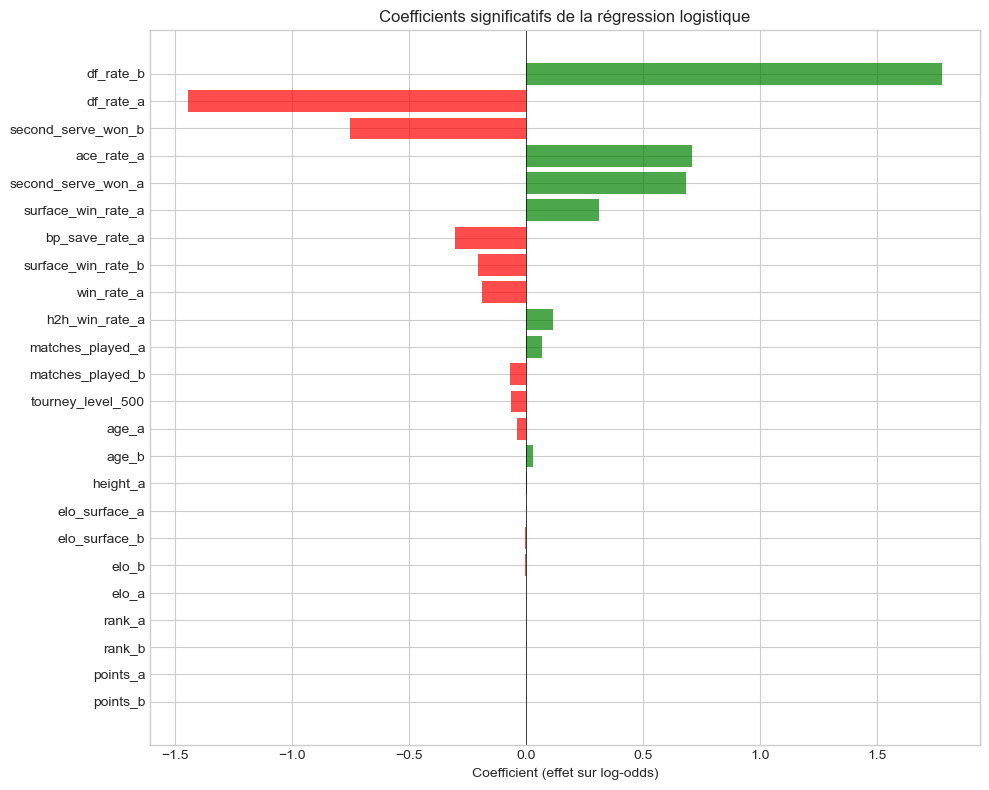

In [32]:
# Visualisation des coefficients significatifs
fig, ax = plt.subplots(figsize=(10, 8))

# Trier par valeur absolue du coefficient
sig_sorted = significant.reindex(significant['coef'].abs().sort_values(ascending=True).index)

colors = ['green' if c > 0 else 'red' for c in sig_sorted['coef']]
ax.barh(range(len(sig_sorted)), sig_sorted['coef'], color=colors, alpha=0.7)
ax.set_yticks(range(len(sig_sorted)))
ax.set_yticklabels(sig_sorted.index)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Coefficient (effet sur log-odds)')
ax.set_title('Coefficients significatifs de la régression logistique')

plt.tight_layout()
plt.show()

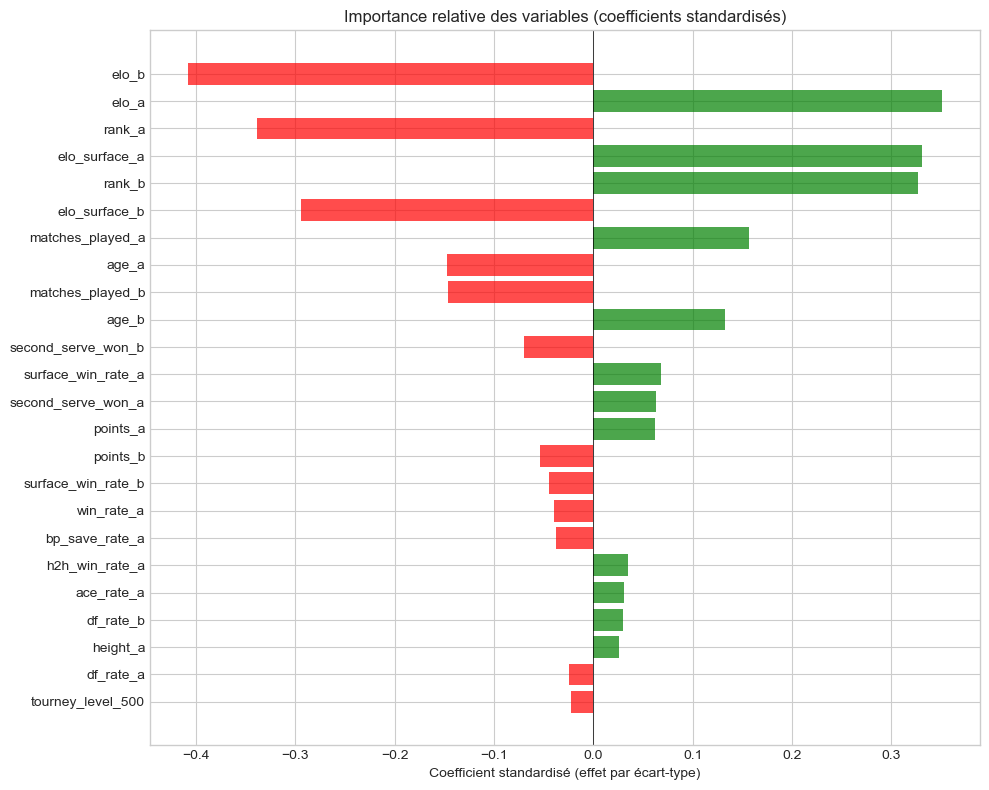

In [33]:
# Coefficients standardisés
std_coefs = significant['coef'] * X_train[significant.index].std()
std_coefs = std_coefs.to_frame(name='coef_std')

# Visualisation des coefficients standardisés
fig, ax = plt.subplots(figsize=(10, 8))

# Trier par valeur absolue du coefficient
std_sorted = std_coefs.reindex(std_coefs['coef_std'].abs().sort_values(ascending=True).index)

colors = ['green' if c > 0 else 'red' for c in std_sorted['coef_std']]     
ax.barh(range(len(std_sorted)), std_sorted['coef_std'], color=colors, alpha=0.7)
ax.set_yticks(range(len(std_sorted)))
ax.set_yticklabels(std_sorted.index)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Coefficient standardisé (effet par écart-type)')
ax.set_title('Importance relative des variables (coefficients standardisés)')

plt.tight_layout()
plt.show()

### Comparaison des deux graphiques (coefficients bruts vs standardisés)

- Vue brute : l’importance apparente est influencée par l’échelle des variables (points/elo/rank ont de gros pas unitaires).
- Vue standardisée : on ramène tout à 1 écart-type, ce qui fait remonter les stats en pourcentage/taux (surface_win_rate, h2h, second_serve_won, df_rate, ace_rate).
- Signal commun : rank/points/elo restent dominants et les signes sont cohérents (favorable à A → proba en hausse, défavorable → proba en baisse).
- Effet d’échelle : points/elo perdent un peu de rang une fois standardisés ; les variables à faible amplitude naturelle (surface_win_rate, second_serve_won, matches_played) montent.
- Variables marginales : height_a, main, round restent en bas dans les deux vues → contribution faible
- Conclusion : le graphique brut montre l’effet par unité, le standardisé montre l’importance relative à échelle comparable (là où se situent vraiment les stats de forme/surface/service).


## 4.5 Évaluation du modèle

Évaluons les performances sur le jeu de test et comparons à la baseline.

Nous utilisons la fonction `evaluate_model()` de `src/training/train.py` qui calcule l'accuracy, le log loss et le ROC AUC.

In [34]:
from evaluation.comparison import evaluate_model

# Évaluation sur le test set
metrics = evaluate_model(model, X_test, y_test)

# Baseline
baseline_pred = (X_test['rank_a'] <= X_test['rank_b']).astype(int)
baseline_acc = (baseline_pred == y_test).mean()

print("=" * 40)
print("RÉSULTATS SUR LE JEU DE TEST")
print("=" * 40)
print(f"\nModèle (Régression Logistique) :")
print(f"  Accuracy : {metrics['accuracy']:.1%}")
print(f"  Log Loss : {metrics['log_loss']:.4f}")
print(f"  ROC AUC  : {metrics['roc_auc']:.4f}")
print(f"\nBaseline (meilleur classement) :")
print(f"  Accuracy : {baseline_acc:.1%}")
print(f"\n→ Amélioration : +{(metrics['accuracy'] - baseline_acc) * 100:.1f} points")

RÉSULTATS SUR LE JEU DE TEST

Modèle (Régression Logistique) :
  Accuracy : 67.7%
  Log Loss : 0.5913
  ROC AUC  : 0.7465

Baseline (meilleur classement) :
  Accuracy : 65.8%

→ Amélioration : +1.9 points


Notre modèle de régression logistique atteint **67.7% d'accuracy**, battant la baseline de +1.9 points. 

Dans la partie suivante, nous allons comparer les prédictions de notre modèle avec celles des bookmakers sur les matchs de 2025.

### Limites et robustesse

- Pas de cross‑validation k‑fold : on a fait un seul split train/test aléatoire, donc l’estimation peut être optimiste ou dépendre du tirage.
- Possible fuite temporelle : mélanger des matchs de saisons différentes peut surévaluer la perf si des infos récentes “influencent” le train. Un split temporel (train ≤ 2024, test = 2025) réduit ce risque.
- Pas de recherche d’hyperparamètres ni régularisation testée (C/penalty) : le modèle peut être légèrement surajusté ou sous‑ajusté.
- Stabilité des coefficients : certaines p‑values peuvent varier d’un split à l’autre ; il faudrait vérifier la stabilité des signes/ordres sur plusieurs splits.
- Conclusion : les résultats sont encourageants mais doivent être revalidés avec cross‑val / split temporel, tuning léger et tests de robustesse pour être pleinement fiables.


---

# Partie 5 : Comparaison avec les Bookmakers

Dans cette partie, nous allons :
1. Ré-entraîner le modèle avec un **split temporel** (train ≤ 2024, test = 2025)
2. Prédire les probabilités de victoire pour les matchs de 2025
3. Comparer nos prédictions avec les cotes des bookmakers
4. Calculer qui prédit le mieux : notre modèle ou les bookmakers ?

## 5.1 Split temporel

- **Train** : matchs de 2000 à 2024
- **Test** : matchs de 2025

Nous utilisons un split temporel (train ≤ 2024, test = 2025) principalement pour permettre la comparaison avec les cotes des bookmakers, disponibles pour les matchs récents de 2025.

**Note** : Ce split n'est pas strictement nécessaire pour éviter le data leakage car nos features sont déjà construites en utilisant uniquement les données antérieures à chaque match (approche "point-in-time"). Un split aléatoire aurait été théoriquement valide, mais le split temporel facilite la collecte des cotes.

Nous utilisons la méthode `preprocessor.split_temporal()` de `src/preprocessing/pipeline.py` qui retourne également les métadonnées (noms des joueurs, dates) nécessaires pour le matching avec les cotes des bookmakers.

In [35]:
# Split temporel : train ≤ 2024, test = 2025
X_train_temp, X_test_2025, y_train_temp, y_test_2025, meta_test = preprocessor.split_temporal(
    features_clean, cutoff_year=2024
)

print(f"Train (≤2024) : {len(X_train_temp):,} matchs")
print(f"Test (2025)   : {len(X_test_2025):,} matchs")
print(f"\nMétadonnées disponibles pour le matching :")
print(meta_test.head())

Train (≤2024) : 72,286 matchs
Test (2025)   : 2,722 matchs

Métadonnées disponibles pour le matching :
  tourney_date  rank_a  rank_b
0   2025-01-06    47.0    58.0
1   2025-01-06    51.0    68.0
2   2025-01-06    60.0    64.0
3   2025-01-06    63.0    77.0
4   2025-01-06    94.0   179.0


## 5.2 Ré-entraînement du modèle

Nous ré-entraînons le modèle `StatsLogitClassifier` sur les données jusqu'à 2024 pour prédire les matchs de 2025.

In [36]:
# Ré-entraîner le modèle sur les données ≤ 2024
model_temporal = StatsLogitClassifier()
model_temporal.fit(X_train_temp,y_train_temp)

# Évaluer sur 2025
metrics_2025 = evaluate_model(model_temporal, X_test_2025, y_test_2025)

print("Performance du modèle sur les matchs 2025 :")
print(f"  Accuracy : {metrics_2025['accuracy']:.1%}")
print(f"  Log Loss : {metrics_2025['log_loss']:.4f}")
print(f"  ROC AUC  : {metrics_2025['roc_auc']:.4f}")

Performance du modèle sur les matchs 2025 :
  Accuracy : 65.9%
  Log Loss : 0.6105
  ROC AUC  : 0.7218


## 5.3 Chargement des cotes des bookmakers

Nous chargeons les cotes des bookmakers depuis [tennis-data.co.uk](http://www.tennis-data.co.uk/alldata.php).

Nous utilisons les cotes **Bet365** car elles sont disponibles dans notre source de données. Ce bookmaker est l'un des plus importants du marché, ses cotes sont représentatives de l'ensemble du marché.

Le matching entre nos données et les cotes se fait via les **classements ATP** (`rank_a`, `rank_b`) et la date du match, plutôt que par les noms des joueurs. Cette approche est plus robuste car les formats de noms diffèrent entre les datasets (accents, abréviations).

In [37]:
from evaluation.bookmakers import load_bookmaker_odds, merge_odds_with_features

# Charger les cotes Bet365 pour 2025 depuis tennis-data.co.uk
odds_df = load_bookmaker_odds(start_year=2025, end_year=2025, bookmaker='B365')

print(f"\nAperçu des données :")
odds_df.head()


Aperçu des données :


,tourney_date,winner_rank,loser_rank,odds_winner,odds_loser
0,2024-12-29,68,52.0,2.00,1.80
1,2024-12-30,41,64.0,1.44,2.75
2,2024-12-30,75,23.0,1.67,2.20
3,2024-12-30,69,59.0,1.53,2.50
4,2024-12-30,26,34.0,2.63,1.50


In [38]:
# Merger les cotes avec nos métadonnées (matching sur date + classements)
matches_with_odds, y_test_odds, idx_matched = merge_odds_with_features(
    meta_test, odds_df, y_test_2025
)

# Récupérer les features correspondantes
X_test_odds = X_test_2025.iloc[idx_matched].reset_index(drop=True)

print(f"Matchs avec cotes : {len(matches_with_odds)} / {len(meta_test)} ({len(matches_with_odds)/len(meta_test)*100:.1f}%)")
print(f"\nAperçu :")
matches_with_odds.head()

Matchs avec cotes : 316 / 2722 (11.6%)

Aperçu :


,tourney_date,rank_a,rank_b,odds_a,odds_b
0,2025-01-06,47.0,58.0,2.30,1.62
1,2025-01-06,51.0,68.0,2.10,1.73
2,2025-01-06,60.0,64.0,2.30,1.62
3,2025-01-06,63.0,77.0,2.38,1.57
4,2025-01-06,59.0,93.0,1.30,3.50


Ce taux de matching de ~12% est attendu : tennis-data.co.uk couvre principalement les tournois majeurs (ATP 250 et plus) où les bookmakers proposent des cotes avec suffisamment de liquidité. Les tournois Challenger et les qualifications, qui représentent une part importante de notre dataset, ne sont généralement pas couverts. Nous considérons avoir une quantité de données suffisante pour faire une comparaison assez exhaustive. 

## 5.4 Comparaison des performances : Modèle vs Bookmakers

Nous utilisons la fonction `compare_accuracy()` de `src/evaluation/comparison.py` pour comparer :
- L'accuracy du modèle vs celle des bookmakers
- Sur combien de matchs les prédictions divergent
- Qui a raison quand ils ne sont pas d'accord

In [39]:
from evaluation.comparison import compare_accuracy

# Prédictions du modèle sur les matchs avec cotes
model_proba = model_temporal.predict_proba(X_test_odds)[:, 1]

# Comparer avec les bookmakers
comparison = compare_accuracy(
    model_proba=model_proba,
    bookmaker_odds_a=matches_with_odds['odds_a'].values,
    bookmaker_odds_b=matches_with_odds['odds_b'].values,
    actual_results=y_test_odds.values
)

print("=" * 50)
print("COMPARAISON MODÈLE vs BOOKMAKERS")
print("=" * 50)
print(f"\nNombre de matchs analysés : {comparison['n_matches']}")
print(f"\nAccuracy :")
print(f"  Modèle     : {comparison['model_accuracy']:.1%}")
print(f"  Bookmakers : {comparison['bookmaker_accuracy']:.1%}")
print(f"  Différence : {comparison['accuracy_diff']:+.1%}")
print(f"\nMatchs où les prédictions divergent : {comparison['n_disagree']}")
if comparison['n_disagree'] > 0:
    print(f"  Modèle correct     : {comparison['model_wins_when_disagree']} ({comparison['model_wins_when_disagree']/comparison['n_disagree']:.1%})")
    print(f"  Bookmakers correct : {comparison['bookmaker_wins_when_disagree']} ({comparison['bookmaker_wins_when_disagree']/comparison['n_disagree']:.1%})")

COMPARAISON MODÈLE vs BOOKMAKERS

Nombre de matchs analysés : 316

Accuracy :
  Modèle     : 67.4%
  Bookmakers : 72.2%
  Différence : -4.7%

Matchs où les prédictions divergent : 43
  Modèle correct     : 14 (32.6%)
  Bookmakers correct : 29 (67.4%)


Les bookmakers ont donc des prédictions plus précises que nous mais notre modèle est assez compétitif et en accord avec les bookmakers sur une majorité des matchs. 

## 5.5 Identification des Value Bets

Un **value bet** est un pari où la probabilité estimée par notre modèle est supérieure à celle implicite du bookmaker. Autrement dit, on pense que le bookmaker sous-estime les chances d'un joueur.

**Expected Value (EV)** = (probabilité modèle × cote bookmaker) - 1

- Si EV > 0, c'est un value bet : l'espérance mathématique du pari est positive
- Si EV < 0, le pari a une espérance négative (ce qui est le cas de la majorité des paris, à cause de la marge du bookmaker)

Notre stratégie de value bets recherche les opportunités sur **les deux joueurs** : si notre modèle estime que le joueur A a 60% de chances de gagner mais que la cote implique seulement 50%, c'est un value bet sur A. Inversement, si notre modèle donne 40% à A mais que la cote implique 50%, c'est un value bet sur B.

Nous utilisons la fonction `find_value_bets()` de `src/evaluation/comparison.py`.

In [41]:
from evaluation.comparison import find_value_bets

# Identifier les value bets
value_bets_df = find_value_bets(
    model_proba=model_proba,
    odds_a=matches_with_odds['odds_a'].values,
    odds_b=matches_with_odds['odds_b'].values,
    threshold=0.0
)

n_value_bets = value_bets_df['is_value_bet'].sum()
n_value_bets_a = value_bets_df['is_value_bet_a'].sum()
n_value_bets_b = value_bets_df['is_value_bet_b'].sum()

print(f"Value bets identifiés : {n_value_bets} / {len(value_bets_df)} matchs ({n_value_bets/len(value_bets_df)*100:.1f}%)")
print(f"  - Sur player A : {n_value_bets_a}")
print(f"  - Sur player B : {n_value_bets_b}")

if n_value_bets > 0:
    # EV moyenne sur les value bets de chaque côté
    ev_a_mean = value_bets_df.loc[value_bets_df['is_value_bet_a'], 'ev_a'].mean()
    ev_b_mean = value_bets_df.loc[value_bets_df['is_value_bet_b'], 'ev_b'].mean()
    print(f"\nExpected Value moyenne :")
    print(f"  - Value bets sur A : {ev_a_mean:.2%}")
    print(f"  - Value bets sur B : {ev_b_mean:.2%}")
    
    print("\nAperçu des value bets :")
    display(value_bets_df[value_bets_df['is_value_bet']].head())

Value bets identifiés : 248 / 316 matchs (78.5%)
  - Sur player A : 129
  - Sur player B : 119

Expected Value moyenne :
  - Value bets sur A : 25.85%
  - Value bets sur B : 19.88%

Aperçu des value bets :


,model_proba_a,model_proba_b,odds_a,odds_b,bookmaker_proba_a,bookmaker_proba_b,ev_a,ev_b,is_value_bet_a,is_value_bet_b,is_value_bet
0,0.359307,0.640693,2.30,1.62,0.434783,0.617284,-0.173595,0.037923,False,True,True
1,0.514854,0.485146,2.10,1.73,0.476190,0.578035,0.081193,-0.160697,True,False,True
2,0.527935,0.472065,2.30,1.62,0.434783,0.617284,0.214250,-0.235255,True,False,True
3,0.470126,0.529874,2.38,1.57,0.420168,0.636943,0.118900,-0.168098,True,False,True
4,0.535138,0.464862,1.30,3.50,0.769231,0.285714,-0.304321,0.627018,False,True,True


Notre modèle identifie des value bets sur **78.5% des matchs** (248/316), ce qui est élevé. Cela s'explique par deux facteurs :

1. **Divergence des estimations** : notre modèle et les bookmakers n'utilisent pas les mêmes informations. Dès qu'il y a une différence d'estimation des probabilités, un value bet apparaît d'un côté ou de l'autre.

2. **Marge du bookmaker** : les bookmakers appliquent une marge (~5%), ce qui fait que la somme des probabilités implicites dépasse 100%. Sans cette marge, on aurait des value bets sur **100% des matchs** (sur A ou sur B) dès que notre estimation diffère de celle du bookmaker. La marge "absorbe" une partie des petites divergences, d'où les 78.5% au lieu de 100%.

La répartition quasi-équilibrée entre A (129) et B (119) confirme que notre randomisation fonctionne correctement et que le modèle n'a pas de biais systématique.

- **EV moyenne sur A : 25.85%**
- **EV moyenne sur B : 19.88%**

**Attention** : une Expected Value positive en théorie ne garantit pas un profit réel. L'EV est calculée avec les probabilités de *notre* modèle, qui a une accuracy inférieure aux bookmakers. Si nos probabilités sont mal calibrées, les "value bets" identifiés ne sont pas de vrais value bets 

## 5.6 Simulation du ROI

Calculons le **Return On Investment (ROI)** simulé si on avait parié selon notre modèle :

1. **Stratégie 1** : Parier sur toutes les prédictions du modèle
2. **Stratégie 2** : Parier uniquement sur les value bets (EV > threshold)


Nous utilisons les fonctions `calculate_roi_evolution()` et `analyze_threshold_impact()` de `src/evaluation/comparison.py`.

### 5.6.1 Simulation du ROI pour la stratégie 1

On va visualiser le Roi en fonction du nombre de paris si on pariait sur toutes les prédictions du modèle

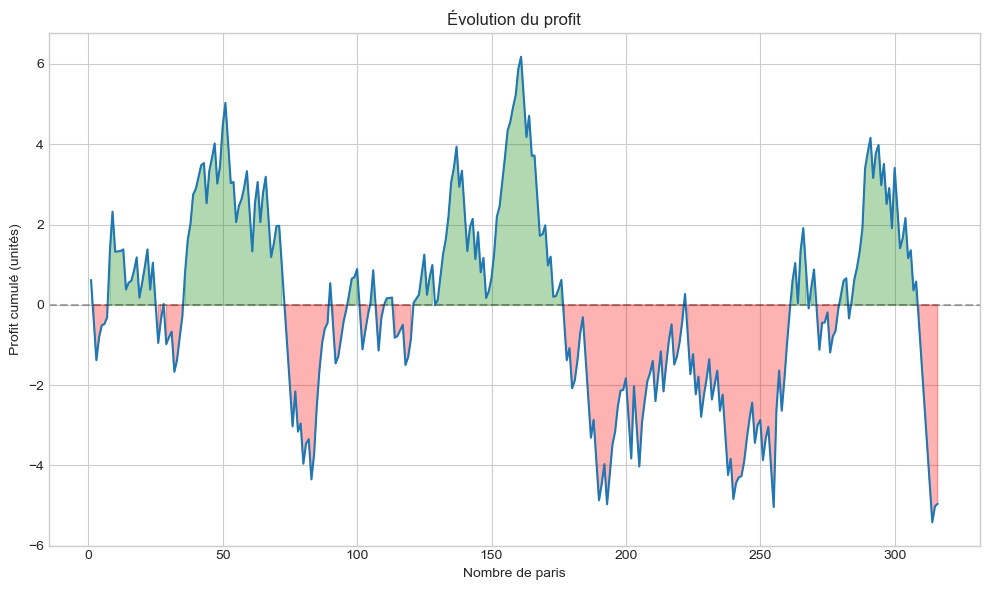

In [42]:
from evaluation.comparison import calculate_roi_evolution

model_pred=model.predict(X_test_odds)

# Évolution du ROI
roi_evolution = calculate_roi_evolution(
    predictions=model_pred,
    actual_results=y_test_odds.values,
    odds_a=matches_with_odds['odds_a'].values,
    odds_b=matches_with_odds['odds_b'].values
)

# Visualisation
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graphique 1 : Profit cumulé
ax1.plot(roi_evolution['n_bets'], roi_evolution['cumul_profit'], linewidth=1.5)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax1.fill_between(roi_evolution['n_bets'], roi_evolution['cumul_profit'], 0,
                where=roi_evolution['cumul_profit'] >= 0, alpha=0.3, color='green')
ax1.fill_between(roi_evolution['n_bets'], roi_evolution['cumul_profit'], 0,
                where=roi_evolution['cumul_profit'] < 0, alpha=0.3, color='red')
ax1.set_xlabel('Nombre de paris')
ax1.set_ylabel('Profit cumulé (unités)')
ax1.set_title('Évolution du profit')


plt.tight_layout()
plt.show()

Le graphique montre l'évolution du profit cumulé si l'on avait parié sur chaque match selon la prédiction du modèle. On observe :

- Une **forte volatilité** : le profit oscille entre +6 et -5 unités au cours des 316 paris
- **Aucune tendance claire** à la hausse ou à la baisse : les phases de gains (vert) alternent avec les phases de pertes (rouge)
- Un **profit final légèrement négatif** (~-5 unités), soit un ROI d'environ -1.5%

Ce comportement est caractéristique d'une stratégie sans edge significatif : les gains et pertes s'annulent globalement, avec une légère perte due à la marge du bookmaker (~5%). Notre modèle, avec une accuracy inférieure à celle des bookmakers (~67% vs ~72%), ne parvient pas à compenser cette marge.

**Conclusion** : parier systématiquement selon notre modèle n'est pas une stratégie rentable, ce qui est cohérent avec nos attentes.

### 5.6.2 Stratégie 2: 
On va visualiser le ROI si on pariait que sur les values bets, pour différents threshold, c'est à dire on parie que si: 

**cote_modèle x (1 + threshold) < cote_bookmakers**

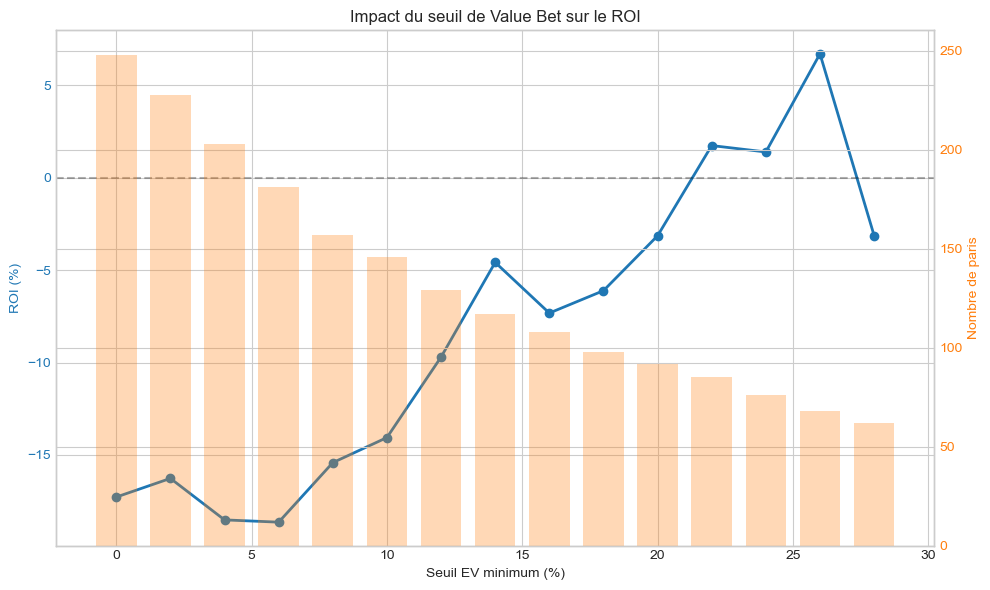

In [43]:
from evaluation.comparison import analyze_threshold_impact

# Visualisation de la stratégie 2
threshold_df = analyze_threshold_impact(
    model_proba=model_proba,
    actual_results=y_test_odds.values,
    odds_a=matches_with_odds['odds_a'].values,
    odds_b=matches_with_odds['odds_b'].values
)

# Visualisation
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Seuil EV minimum (%)')
ax1.set_ylabel('ROI (%)', color='tab:blue')
ax1.plot(threshold_df['threshold_pct'], threshold_df['roi'], 'o-', color='tab:blue', linewidth=2)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Nombre de paris', color='tab:orange')
ax2.bar(threshold_df['threshold_pct'], threshold_df['n_bets'], alpha=0.3, color='tab:orange', width=1.5)
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Impact du seuil de Value Bet sur le ROI')
fig.tight_layout()
plt.show()

Le graphique montre le ROI en fonction du seuil d'Expected Value minimum pour placer un pari :

- **Seuils bas (0-10%)** : ROI fortement négatif (-15% à -17%), malgré un grand nombre de paris (~200-250). Cela indique que notre modèle identifie mal les "value bets" à faible edge.

- **Seuils moyens (10-20%)** : ROI qui remonte progressivement mais reste négatif (-10% à -3%), avec moins de paris (~100-150).

- **Seuils élevés (20-28%)** : ROI qui devient légèrement positif (+1% à +7%) pour un seuil autour de 25%, mais avec très peu de paris (~50-70).

**Attention à l'interprétation** : le pic de ROI à ~25% de seuil repose sur un échantillon très réduit (~50 paris). Cette apparente rentabilité pourrait être due au hasard plutôt qu'à un vrai edge du modèle. Sur un échantillon aussi petit, la variance est élevée et les résultats ne sont pas statistiquement significatifs.

**Conclusion** : même la stratégie de value bets ne garantit pas de profit fiable. Les rares configurations "rentables" reposent sur trop peu de paris pour être exploitables en pratique.

---

## 5.7 Conclusion de la comparaison avec les bookmakers

### Résumé des résultats

| Métrique | Modèle | Bookmakers |
|----------|--------|------------|
| Accuracy | ~67% | ~72% |
| ROI stratégie 1 (tous les paris) | ~-1.5% | - |
| ROI stratégie 2 (seuil optimal ~25%) | ~+5% | - |
| Nombre de paris (seuil optimal) | ~50 | - |

### Interprétation

Les résultats confirment la difficulté de battre les bookmakers :

1. **Stratégie 1** : parier sur toutes nos prédictions génère un ROI légèrement négatif, absorbé par la marge du bookmaker. Sans avantage informationnel, l'espérance est négative.

2. **Stratégie 2** : la sélection de value bets avec un seuil élevé semble générer un léger profit, mais ce résultat n'est pas fiable statistiquement (trop peu de paris, variance élevée).

Notre modèle, basé uniquement sur des données historiques publiques, ne dispose pas d'un edge suffisant pour être rentable. Les bookmakers intègrent des informations supplémentaires (blessures, forme récente, conditions de jeu) que nous n'avons pas.

### Limites de l'analyse

1. **Échantillon limité** : ~316 matchs, dont seulement ~50 pour le seuil "optimal" - résultats non significatifs statistiquement
2. **Biais de sélection** : comparaison uniquement sur les tournois majeurs couverts par les bookmakers
3. **Frais non inclus** : les commissions réduiraient encore le ROI réel
4. **Cotes de clôture** : pas nécessairement les cotes disponibles au moment du pari
5. **Surapprentissage potentiel** : le seuil "optimal" est choisi a posteriori sur les mêmes données

---

# Conclusion Générale

## Récapitulatif du projet

Dans ce projet, nous avons développé un modèle de prédiction de matchs de tennis ATP :

1. **Exploration des données** : 77,939 matchs ATP (2000-2025)
2. **Feature engineering** :
   - Features statiques (classement, âge, taille)
   - Features Elo (global et par surface, calculées dynamiquement)
   - Features historiques avec decay temporel (win rate, stats de service)
   - Features spécifiques (surface win rate, head-to-head)
3. **Modélisation** : Régression logistique interprétable avec `StatsLogitClassifier`
4. **Évaluation** : Accuracy de ~67.7% (vs baseline de 65.4%)
5. **Comparaison bookmakers** : Analyse des value bets et simulation du ROI

## Points clés

- Le **classement ATP** (points et rang) reste le meilleur prédicteur
- L'**Elo** apporte une information complémentaire au classement (mise à jour dynamique match par match)
- Les **features historiques** (win rate, surface win rate) améliorent significativement le modèle
- Les variables physiques (taille, main dominante) ne sont **pas significatives**
- Le modèle bat la baseline naïve mais reste en-deçà des bookmakers professionnels

## Pistes d'amélioration

1. **Modèles plus complexes** : Random Forest, XGBoost, réseaux de neurones
2. **Features supplémentaires** : fatigue, conditions météo, historique sur le tournoi
3. **Données en temps réel** : cotes en direct, blessures, forfaits
4. **Calibration des probabilités** : améliorer l'estimation des probabilités pour le betting